In [1]:
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
infile = infile = '../datasets/alanine/COLVAR_T450'
phi, psi=np.loadtxt(infile, unpack=True, usecols=(1,2), skiprows=7)

There are 100,000 rows that are present in the file. We will be using the first 2000 for training and 500 for validation. Then we give the first 2500 for test an generate the next 1000 to see the accuracy.

In [8]:
device = torch.device("cuda")


def running_mean(x, N):
    """Use convolution to do running average."""
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def find_nearest(key_arr, target):
    """key_arr: array-like, storing keys.
       target: the value which we want to be closest to."""
    idx=np.abs(key_arr-target).argmin()
    return idx

def Rm_peaks_steps(traj):
    global threshold
    """
    Remove sudden changes in the trajectory such as peaks and small steps.
    In this method, I used gradient to identify the changes. If two nonzero
    gradients are too close (< threshold), we shall take this range as noise.
    """
    traj=np.array(traj)
    grad_traj=np.gradient(traj) # gradient of trajectory
    idx_grad=np.where(grad_traj!=0)[0]
    threshold=20
    idx0=idx_grad[0]
    for idx in idx_grad:
        window=idx-idx0
        if window <= 1: # neighbor
            continue
        elif window > 1 and window <= threshold:
            traj[idx0:idx0+window//2+1]=traj[idx0]
            traj[idx0+window//2+1:idx+1]=traj[idx+1]
            idx0=idx
        elif window > threshold:
            idx0=idx
    return traj

## Preprocessing

In [66]:
bins=np.arange(-0.9, 1.1, 0.1)
num_bins=len(bins)
# Labels of all possible states in the ranges we considered.
# For 2d systems, this is not the same as the number of representative values.
all_combs = [i for i in range(num_bins)]
vocab=sorted(all_combs)
vocab_size = len(vocab)

# Sequence length and shift in step between past (input) & future (output)

# Batch size
BATCH_SIZE = 64

# Model parameters
embedding_dim = 128
rnn_units = 1024

# Training epochs
EPOCHS=40

cos_phi=np.cos(phi)
sin_phi=np.sin(phi)
cos_psi=np.cos(psi)
sin_psi=np.sin(psi)

# Spatially discretized data
idx_sin_phi=np.digitize(cos_phi, bins)
idx_sin_psi=np.digitize(sin_psi, bins)

idx_2d=list(idx_sin_phi[:10000])
text = idx_2d

char2idx = {u:i for i, u in enumerate(vocab)} # Mapping from characters to indices
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

idx_sin_phi_v=np.digitize(sin_phi, bins)
idx_2dv=list(idx_sin_phi_v)

vali = idx_2dv[:200000]
vali_as_int = np.array([char2idx[c] for c in vali])


In [67]:
class NLP(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, rnn_units, batch_size):
        
        super(NLP, self).__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = rnn_units
        self.num_layers = 1
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(self.input_dim, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.input_dim)
        self.hidden = self.init_hidden()
#         self.hidden = self.hidden.to('cuda')
    
    def init_hidden(self):
        
        return (nn.Parameter(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)).to('cuda'),
                nn.Parameter(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)).to('cuda'))
    
    def forward(self, input):
        
        embedding_out = self.embedding(input)
        lstm_in = embedding_out.view(self.batch_size, input.shape[1], self.embedding_dim)
        lstm_out, self.hidden = self.lstm(lstm_in, self.hidden)
        y_pred = self.linear(lstm_out)
        
        return y_pred
    
class NLP_GRU(nn.Module):
    """
    Some bug present in code
    """
    def __init__(self, input_dim, embedding_dim, rnn_units, batch_size):
        
        super(NLP_GRU, self).__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = rnn_units
        self.num_layers = 1
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(self.embedding_dim,self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, self.input_dim)
        self.hidden = self.init_hidden()
        
        self.gru = nn.GRU(self.hidden_dim, self.hidden_dim, self.num_layers, batch_first=True)
    
    def init_hidden(self):
        
        return nn.Parameter(torch.zeros(1, self.batch_size, self.hidden_dim)).to('cuda').clone()
    
    def forward(self, input):
        print(input.shape)
        embedding_out = self.embedding(input)
        print(embedding_out.shape)
        gru_in = embedding_out.view(self.batch_size, input.shape[1], self.hidden_dim)
        print(gru_in.shape)
        gru_out, self.hidden = self.gru(gru_in, self.hidden)
        y_pred = self.linear(gru_out)
        
        return y_pred


In [68]:
def batch_data(x, batch_size):
    """input should be a numpy.array or list"""
    remaind = len(x)%batch_size
    y = x[:-remaind]
    num_dataset = len(x)//batch_size
    return y.reshape((num_dataset, batch_size))

class seq_data(Dataset):
    
    def __init__(self, traj, seq_length, shift):
        self.traj = traj
        self.seq_length = seq_length
        self.shift = shift
    
    def __len__(self):
        return self.traj[self.shift:].shape[0]//self.seq_length
    
    def __getitem__(self, idx):
        x = self.traj[:-self.shift][idx*self.seq_length:idx*self.seq_length+self.seq_length]
        y = self.traj[self.shift:][idx*self.seq_length:idx*self.seq_length+self.seq_length]
        return x, y

In [69]:
EPOCHS = 40
sequence_len = 100
shift=1
batch_size=64

train_dataset = seq_data(text_as_int, sequence_len, shift)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

val_dataset = seq_data(vali_as_int, sequence_len, shift)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True)

model = NLP(vocab_size, embedding_dim, rnn_units,batch_size).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(train_dataset.__len__())
print(val_dataset.__len__())

NLP(
  (embedding): Embedding(20, 128)
  (lstm): LSTM(128, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=20, bias=True)
)
99
1999


In [70]:
train_loss=[]
train_accuracy = []

val_loss=[]
val_accuracy = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = []
    model.train()
    for batch_X_train, batch_Y_train in train_dataloader:
        model.hidden[0].detach_()
        model.hidden[1].detach_()
        batch_X_train = batch_X_train.to(device)
        batch_Y_train = batch_Y_train.to(device)
        y_pred = model(batch_X_train)
        y=batch_Y_train.to(device)
        
        loss = loss_fn(y_pred.view(-1, vocab_size), y.view(-1))
        y_pred_soft = torch.nn.functional.softmax(y_pred)
        y_pred_state = torch.argmax(y_pred_soft,axis=2)
        train_pred = torch.sum(y_pred_state==y).cpu().numpy()/(batch_size*sequence_len) 
        epoch_accuracy.append(train_pred)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    train_loss.append(epoch_loss)
    avg_accuracy = np.mean(epoch_accuracy)*100
    train_accuracy.append(avg_accuracy)
    print(f'Train Loss at Epoch {epoch} = {epoch_loss}, Train Accuracy = {avg_accuracy}')
    
    
    epoch_val_loss= 0
    epoch_val_accuracy = []
    model.eval()
    for batch_X_train, batch_Y_train in val_dataloader:
        model.hidden[0].detach_()
        model.hidden[1].detach_()
        batch_X_train = batch_X_train.to(device)
        batch_Y_train = batch_Y_train.to(device)
        y_pred = model(batch_X_train)
        y=batch_Y_train.to(device)
        
        loss = loss_fn(y_pred.view(-1, vocab_size), y.view(-1))
        y_pred_soft = torch.nn.functional.softmax(y_pred)
        y_pred_state = torch.argmax(y_pred_soft,axis=2)
        val_pred = torch.sum(y_pred_state==y).cpu().numpy()/(batch_size*sequence_len) 
        epoch_val_accuracy.append(val_pred)
        epoch_val_loss += loss.item()
        
    val_loss.append(epoch_val_loss/40)
    avg_accuracy = np.mean(epoch_val_accuracy)*100
    val_accuracy.append(avg_accuracy)
    print(f'Val Loss at Epoch {epoch} = {epoch_val_loss/40}, Val Accuracy = {avg_accuracy}')

/home/darthgera123/anaconda3/envs/redner/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/darthgera123/anaconda3/envs/redner/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Loss at Epoch 0 = 2.9636106491088867, Train Accuracy = 13.218750000000002
Val Loss at Epoch 0 = 1.8336318910121918, Val Accuracy = 39.03074596774195
Train Loss at Epoch 1 = 2.6509172916412354, Train Accuracy = 27.03125
Val Loss at Epoch 1 = 1.4772556215524673, Val Accuracy = 31.329637096774192
Train Loss at Epoch 2 = 2.3466849327087402, Train Accuracy = 22.609375
Val Loss at Epoch 2 = 1.5391477406024934, Val Accuracy = 33.97530241935483
Train Loss at Epoch 3 = 2.226356029510498, Train Accuracy = 22.40625
Val Loss at Epoch 3 = 1.5967880129814147, Val Accuracy = 23.225302419354836
Train Loss at Epoch 4 = 2.1439623832702637, Train Accuracy = 22.8125
Val Loss at Epoch 4 = 1.5598181128501891, Val Accuracy = 32.69506048387096
Train Loss at Epoch 5 = 2.129157066345215, Train Accuracy = 22.5625
Val Loss at Epoch 5 = 1.5047309339046477, Val Accuracy = 37.164314516129025
Train Loss at Epoch 6 = 2.0491793155670166, Train Accuracy = 22.125
Val Loss at Epoch 6 = 1.455846333503723, Val Accurac

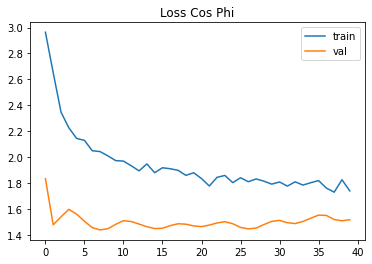

In [71]:
import matplotlib.pyplot as plt
plt.title("Loss")
plt.plot(train_loss,label='train')
plt.title("Loss Cos Phi")
plt.plot(val_loss,label='val')
plt.legend()
plt.savefig("plots/loss_cos_phi.png")

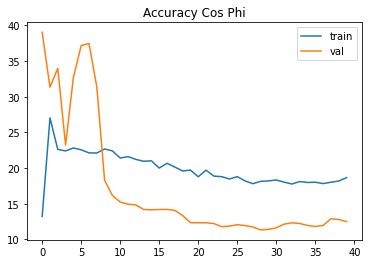

In [72]:
plt.title("Accuracy Cos Phi")
plt.plot(train_accuracy,label='train')
plt.plot(val_accuracy,label='val')
plt.legend()
plt.savefig("plots/accuracy_cos_phi.png")

In [51]:
PATH = 'training_checkpoints/test_weight_16_1000.pt'
torch.save(model.state_dict(), PATH)

In [52]:
model = NLP(vocab_size, embedding_dim, rnn_units, 1).to(device)
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [53]:
def generate_text(start_string,string_length):
    
    input_eval = torch.tensor([char2idx[s] for s in start_string], device=device)
    
    text_generated = np.empty(1)
    
    for i in range(string_length):
        input_eval = input_eval[np.newaxis, ...] # add a dimension for batch=1.
        prediction=model(input_eval)
        logits=prediction
        p=torch.nn.functional.softmax(logits, dim=-1) # take first batch
        predicted_id=torch.multinomial(p[0,-1], 1)
        
        input_eval = predicted_id
        
        text_generated = np.vstack((text_generated, idx2char[predicted_id].tolist()))

    return text_generated[1:]


In [64]:
string_length = 1000
text = idx_2d[:string_length]
prediction=generate_text(text,string_length)

In [65]:
test_accuracy = np.sum(np.ravel(prediction)==idx_2d[string_length:2*string_length])
test_accuracy = (test_accuracy/string_length) * 100
print(f"Accuracy of test prediction of sequence length {string_length} is {test_accuracy}%")

Accuracy of test prediction of sequence length 1000 is 11.4%
